In [2]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots, gofplots
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [230]:
class RandomProcess:
    """Normal stationary random process
    """
    def __init__(self, alpha=1, D=1, q=10, dt=1):
        self.N = q
        self.alpha = alpha
        self.dt = dt
        self.D = D
        self.coeffs = self.find_coeffs()
        
    def R(self, teta):
        return self.D*np.exp(-self.alpha*np.abs(teta))*(1+self.alpha*np.abs(teta))
    
    def rand(self, n, loc):
        self.loc = loc
        self.w = np.random.normal(size=n+self.N, loc=0, scale=1)
        cf = self.coeffs[::-1]
        def get_x(t):
            return loc + sum(cf*self.w[t:self.N+t])
        return [get_x(i) for i in range(n)]
    
    def find_coeffs(self):
        def build_eqs(c):
            eqs = []
            for i in range(self.N):
                b = 0
                for j in range(self.N-i):
                    b += c[j+i]*c[j]
                eqs.append(b - self.R(i*self.dt))
            return eqs
        coeffs = fsolve(build_eqs, np.full(self.N, 1))
        if not all(np.isclose(build_eqs(coeffs), np.zeros(self.N))):
            raise ValueError('Incorrect coeffs found')
        return coeffs

In [242]:
ts = RandomProcess(alpha=0.3, D=2, q=15, dt=2)

In [253]:
vals = ts.rand(3000, 5)

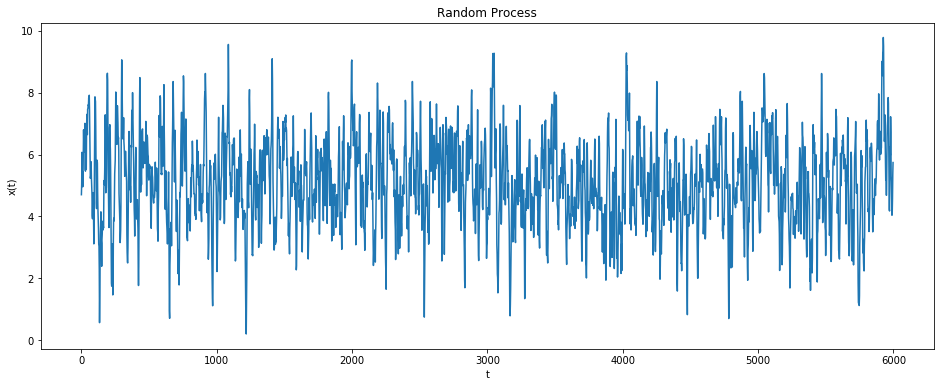

In [254]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(np.arange(0, len(vals)*ts.dt, ts.dt), vals)
plt.title('Random Process')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

## Normality of data

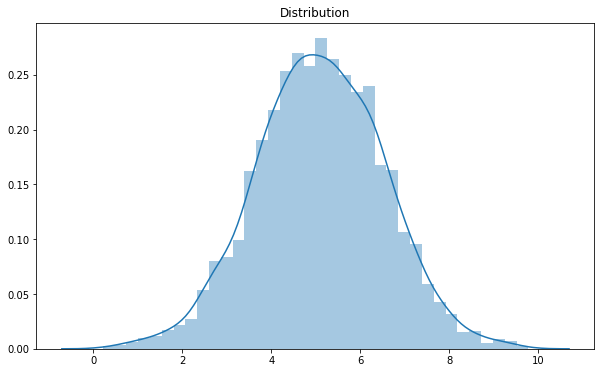

In [255]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(vals)
plt.title('Distribution')
plt.show()

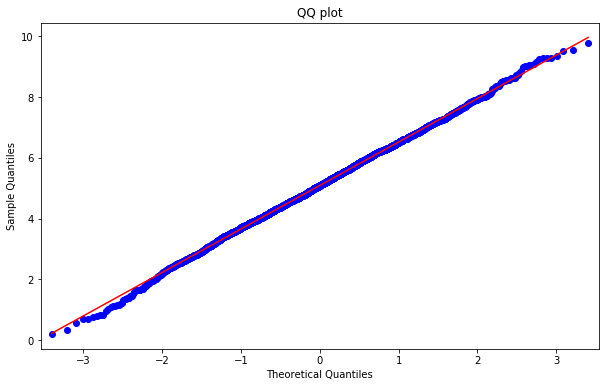

In [256]:
fig, ax = plt.subplots(figsize=(10, 6))
gofplots.qqplot(np.array(vals), ax=ax, line='s')
plt.title('QQ plot')
plt.show()

## Stationary

Augmented Dickey-Fuller test

In [257]:
adfTest = adfuller(vals)
dfResults = dict(zip(['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'], adfTest[0:4]))
for key,value in adfTest[4].items():
    dfResults[f'Critical Value ({key})'] = value
for k, val in dfResults.items():
    print(f'{k:<20}: {val}')

ADF Test Statistic  : -15.10629018632298
P-Value             : 7.8106628105592e-28
# Lags Used         : 7
# Observations Used : 2992
Critical Value (1%) : -3.432537472983712
Critical Value (5%) : -2.8625064838167327
Critical Value (10%): -2.5672844849053806


## Statistics

#### Expected value

theoretical

In [258]:
ts.loc

5

actual

In [259]:
np.mean(vals)

5.090788590477614

#### Variance

theoretical

In [260]:
D0 = 1  # standart normal distribution
D0*(sum(ts.coeffs**2))

1.9999999999998626

actual

In [261]:
np.var(vals)

2.044513381069363

#### Autocorrelation

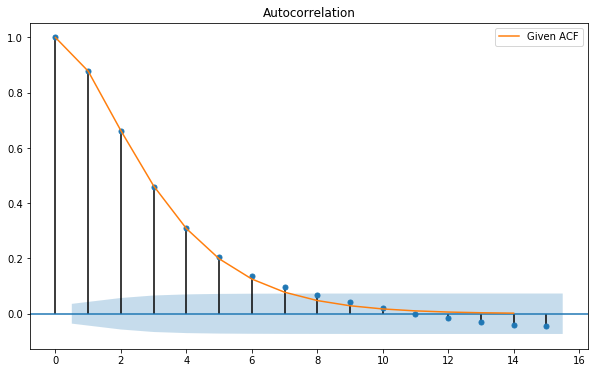

In [262]:
fig, ax = plt.subplots(figsize=(10, 6))
tsaplots.plot_acf(vals, ax, lags=ts.N)
x = np.arange(0, ts.N)
plt.plot(x, ts.R(x*ts.dt)/ts.D, label='Given ACF')
plt.legend()
plt.title('Autocorrelation')
plt.show()